In [ ]:
# 验证码识别器训练 
# Reference: https://github.com/ypwhs/captcha_break

In [1]:
# 导入所有需要的库
import numpy as np
import pandas as pd
np.random.seed(0)
from keras.models import Model,load_model
from keras.layers import *
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
from unicodedata import normalize
from keras import regularizers
from keras.applications import inception_resnet_v2
from keras.layers import Flatten
from keras.utils.np_utils import to_categorical
from PIL import Image as Image__
import glob
from sklearn.model_selection import train_test_split
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
%pylab inline
import random
%config InlineBackend.figure_format = 'retina'
import string
import cv2

C:\Users\Administrator\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


C:\Users\Administrator\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['add', 'average', 'multiply', 'copy', 'subtract', 'concatenate', 'maximum', 'dot', 'minimum']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
from keras.utils import multi_gpu_model
from keras.callbacks import *

In [125]:
string.ascii_letters

'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'

0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ


Text(0.5,1,'loS9')

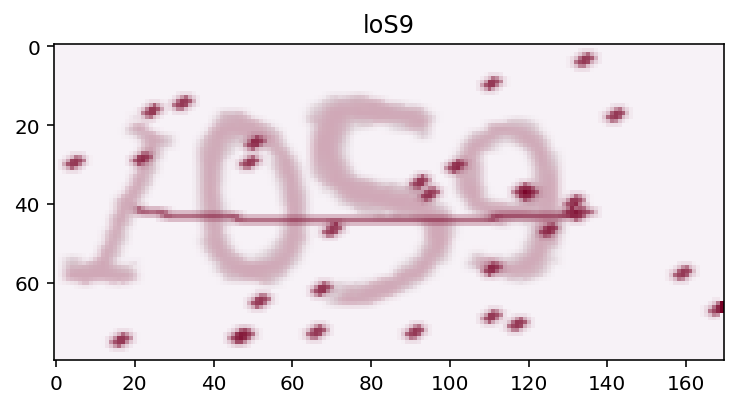

In [187]:
# 随机生成一个5位验证码图片
# 让captcha生成大小170*80图片大小，如果过小会显示错位
# 然后放大图片，因为keras的预训练模型不支持139*139以下图片

characters = string.digits + string.ascii_letters
print(characters)

width, height, n_len, n_class = 130, 80, 4, len(characters)+1

generator = ImageCaptcha(width=width, height=height)
random_str = ''.join([random.choice(characters) for j in range(4)])
img = generator.generate_image(random_str)
img = cv2.resize(np.array(img),(170,80))

plt.imshow(img)
plt.title(random_str)

In [188]:
# ctc loss
from keras import backend as K

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [212]:
# model
rnn_size = 128

input_tensor = Input((width, height, 3))
x = input_tensor
for i in range(3):
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

conv_shape = x.get_shape()
x = Reshape(target_shape=(int(conv_shape[1]), int(conv_shape[2]*conv_shape[3])))(x)

x = Dense(32, activation='relu')(x)

gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(x)
gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru1_b')(x)
gru1_merged = merge([gru_1, gru_1b], mode='sum')

gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru2_b')(gru1_merged)
x = merge([gru_2, gru_2b], mode='concat')
x = Dropout(0.25)(x)
x = Dense(n_class, activation='softmax', kernel_initializer="he_normal")(x)
base_model = Model(input=input_tensor, output=x)

labels = Input(name='the_labels', shape=[n_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([x, labels, input_length, label_length])

model = Model(outputs=[loss_out],inputs=[input_tensor, labels, input_length, label_length])

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
C:\Users\Administrator\Anaconda3\lib\site-packages\keras\legacy\layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [195]:
# 定义训练集batch生成器，每次可生成batchsize个图片
def gen_code(batch_size=128):
    X = np.zeros((batch_size, width, height, 3), dtype=np.uint8)
    y = np.zeros((batch_size, n_len), dtype=np.uint8)
    while True:
        generator = ImageCaptcha(width=width, height=height)
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(4)])
            X[i] = np.array(generator.generate_image(random_str)).transpose(1, 0, 2)
            y[i] = [characters.find(x) for x in random_str]
        yield [X, y, np.ones(batch_size)*int(conv_shape[1]-2), np.ones(batch_size)*n_len], np.ones(batch_size)

In [196]:
# 测试生成器
def test_gen():
    m,n = next(gen_code(batch_size=1))
    X,y = m[:2]
    index = y[0]
    digits = ''.join([characters[i] for i in index])
    plt.imshow(X.transpose(0,2,1,3)[0])
    plt.title(digits)

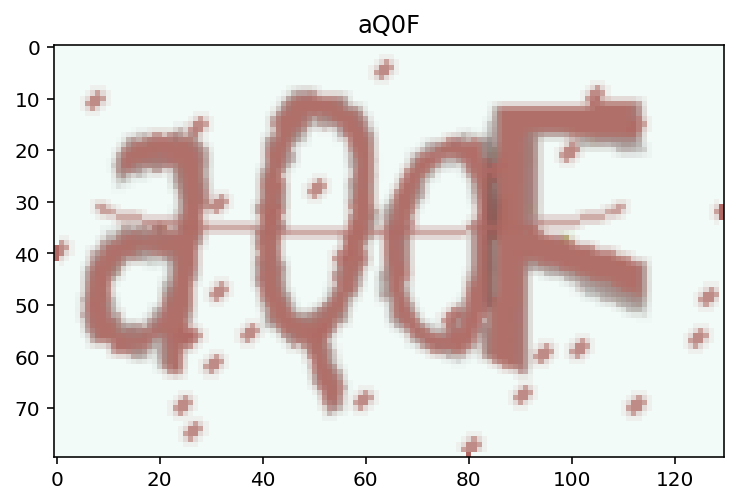

In [197]:
test_gen()

In [214]:
weights.keys()

dict_keys(['input_3', 'conv2d_13', 'conv2d_14', 'max_pooling2d_7', 'conv2d_15', 'conv2d_16', 'max_pooling2d_8', 'conv2d_17', 'conv2d_18', 'max_pooling2d_9', 'reshape_3', 'dense_5', 'gru1', 'gru1_b', 'merge_5', 'gru2', 'gru2_b', 'merge_6', 'dropout_3', 'dense_6', 'the_labels', 'input_length', 'label_length', 'ctc'])

In [230]:
a = weights['dense_6'][0]
b = weights['dense_6'][1]

In [235]:
x = np.zeros([256,n_class])
x[:,:37] = a

In [241]:
y = np.zeros([n_class,])
y[:37] = b

In [242]:
weights['dense_6'] = [x,y]

In [244]:
for i in range(len(model.layers)):
    layer = model.layers[i]
    layer.set_weights(list(weights.values())[i])

In [198]:
model.load_weights('model.h5')

In [211]:
weights = dict([layer.name,layer.get_weights()] for layer in model.layers)

In [ ]:
#model.summary()

In [ ]:
# 时间超级尼玛长
#parallel_model = multi_gpu_model(model, gpus=8)

In [ ]:
#parallel_model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adam')

In [10]:
# 训练
def evaluate(model, batch_num=10):
    batch_acc = 0
    generator = gen_code(128)
    for i in range(batch_num):
        [X_test, y_test, _, _], _  = next(generator)
        y_pred = base_model.predict(X_test)
        shape = y_pred[:,2:,:].shape
        out = K.get_value(K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0])[:, :4]
        if out.shape[1] == 4:
            batch_acc += ((y_test == out).sum(axis=1) == 4).mean()
    return batch_acc / batch_num

In [12]:
class Evaluate(Callback):
    def __init__(self):
        self.accs = []
    
    def on_epoch_end(self, epoch, logs=None):
        acc = evaluate(base_model)*100
        self.accs.append(acc)
        print
        print ('acc: %f%%'%acc)

evaluator = Evaluate()

In [ ]:
#parallel_model.fit_generator(gen_code(128), validation_data=gen_code(), steps_per_epoch=5200, epochs=5,
 #                   callbacks=[EarlyStopping(patience=10), evaluator],validation_steps=1280)

In [246]:
model.save('model.h5')

In [93]:
[X_test, y_test, _, _], _  = next(gen_code(1))

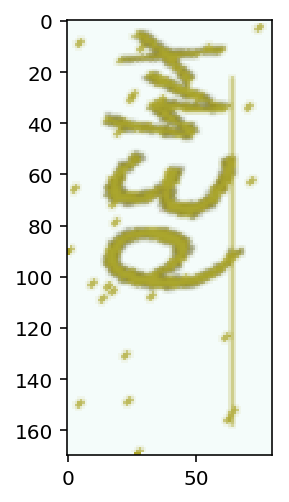

In [98]:
plt.imshow(X_test[0])

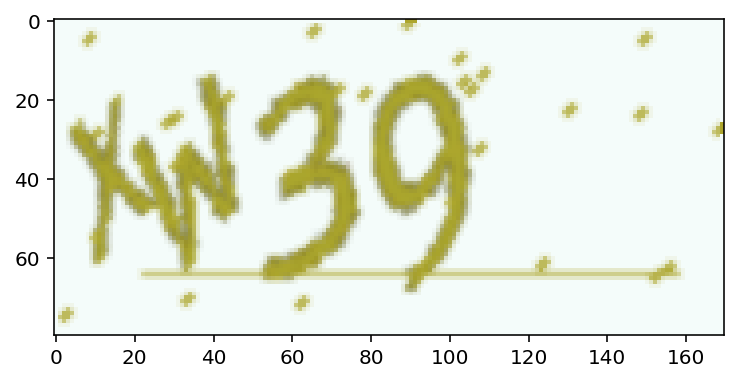

In [99]:
plt.imshow(X_test[0].transpose([1,0,2]))

[(8, '8'),
 (36, ' '),
 (12, 'C'),
 (36, ' '),
 (17, 'H'),
 (36, ' '),
 (13, 'D'),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' ')]

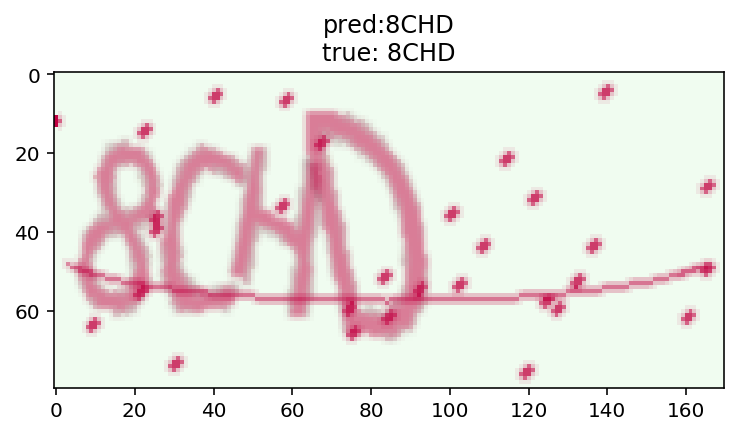

In [121]:
characters2 = characters + ' '
[X_test, y_test, _, _], _  = next(gen_code(1))
y_pred = base_model.predict(X_test)
y_pred = y_pred[:,2:,:]
out = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0])*y_pred.shape[1], )[0][0])[:, :4]
out = ''.join([characters[x] for x in out[0]])
y_true = ''.join([characters[x] for x in y_test[0]])

plt.imshow(X_test[0].transpose(1, 0, 2))
plt.title('pred:' + str(out) + '\ntrue: ' + str(y_true))

argmax = np.argmax(y_pred, axis=2)[0]
list(zip(argmax, ''.join([characters2[x] for x in argmax])))

In [14]:
X_test.shape

(1, 170, 80, 3)

In [101]:
X_test = cv2.imread('./examples/weibo.png')

In [102]:
X_test = X_test.transpose(1,0,2)[15:,:,:]

In [103]:
X_test = cv2.resize(X_test,(80,170))

In [104]:
X_test.shape

(170, 80, 3)

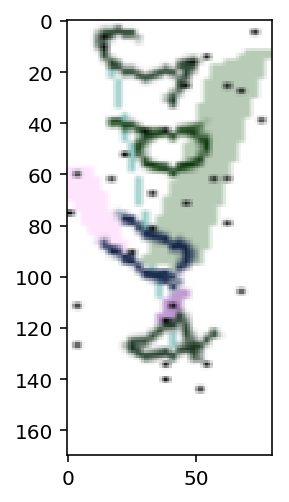

In [109]:
plt.imshow(X_test[0])

In [106]:
X_test = X_test.reshape(1,170,80,3)

[(10, 'A'),
 (36, ' '),
 (13, 'D'),
 (36, ' '),
 (4, '4'),
 (36, ' '),
 (4, '4'),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' ')]

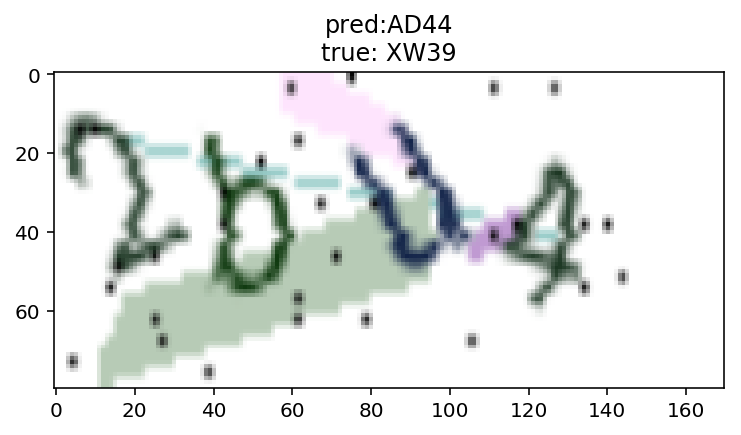

In [107]:
characters2 = characters + ' '
y_pred = base_model.predict(X_test)
y_pred = y_pred[:,2:,:]
out = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0])*y_pred.shape[1], )[0][0])[:, :4]
out = ''.join([characters[x] for x in out[0]])
y_true = ''.join([characters[x] for x in y_test[0]])

plt.imshow(X_test[0].transpose(1, 0, 2))
plt.title('pred:' + str(out) + '\ntrue: ' + str(y_true))

argmax = np.argmax(y_pred, axis=2)[0]
list(zip(argmax, ''.join([characters2[x] for x in argmax])))

In [ ]:
# evaluate
evaluate(base_model)